In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from scipy.io import loadmat
from scipy.optimize import minimize, fmin_cg
from IPython import display
from collections import namedtuple
from surprise.prediction_algorithms.matrix_factorization import SVD

## Load Data

$Y$ is the **ratings** matrix, $Y(i,j) \in \{0,1,2,3,4,5\}$

$R$ is the **rated status** matrix, $R(i,j) \in \{0,1\}$

$Y, R \in \mathbb{R}^{n_m \times n_u}$

In [3]:
data = loadmat('ex8_movies.mat')
Y, R = data['Y'].astype(np.float64), data['R'].astype(np.float64)

In [4]:
Y.shape, R.shape

((1682, 943), (1682, 943))

$X$ is the **movie features** matrix, $X \in \mathbb{R}^{n_m \times 10}$

$Theta$ is the **user parameters** matrix, $Theta \in \mathbb{R}^{n_u \times 10}$

In [5]:
n_features = 100
X = np.zeros((Y.shape[0], n_features))
Theta = np.zeros((Y.shape[1], n_features))

In [6]:
X.shape, Theta.shape

((1682, 100), (943, 100))

## Cost Function

$\displaystyle J(x^{(1)},\dots,x^{(n_m)},\theta^{(1)},\dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} ((\theta^{(j)})^{\top} x^{(i)} - y^{(i,j)})^2 + \left(\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^{n}(\theta_{k}^{(j)})^2\right) + \left(\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^{n}(x_{k}^{(i)})^2\right)$

In [7]:
params = loadmat('ex8_movieParams.mat')
X, Theta = params['X'], params['Theta']

In [8]:
def cost(X, Theta, Y, R, lamb=0):
    X_reg = (lamb/2) * np.sum(X**2)
    Theta_reg = (lamb/2) * np.sum(Theta**2)
    return (np.sum(np.square(R * (X @ Theta.T - Y))) / 2) + X_reg + Theta_reg

In [9]:
c = cost(X[:5,:3], Theta[:4,:3], Y[:5,:4], R[:5,:4])
print(f'The cost is {c:.2f}')

The cost is 22.22


In [10]:
c = cost(X[:5,:3], Theta[:4,:3], Y[:5,:4], R[:5,:4], lamb=1.5)
print(f'The regularized cost is {c:.2f}')

The regularized cost is 31.34


In [11]:
cost(X, Theta, Y, R)

27918.64012454421

## Gradient Function

$\displaystyle \frac{\partial\,J}{\partial\,x_{k}^{(i)}} = \sum_{j:r(i,\,j)=1} ((\theta^{(j)})^{\top}x^{(i)}-y^{(i,\,j)})\theta_{k}^{(j)} + \lambda x_{k}^{(i)}$

$\displaystyle \frac{\partial\,J}{\partial\,\theta_{k}^{(j)}} = \sum_{i:r(i,\,j)=1} ((\theta^{(j)})^{\top}x^{(i)}-y^{(i,\,j)})x_{k}^{(i)} + \lambda \theta_{k}^{(j)}$

In [12]:
def gradient(X, Theta, Y, R, lamb=0):
    diffs = R * (X @ Theta.T - Y)
    X_reg = lamb * X
    Theta_reg = lamb * Theta
    X_grad = diffs @ Theta + X_reg
    Theta_grad = diffs.T @ X + Theta_reg
    return X_grad, Theta_grad

In [13]:
np.all(np.isclose(gradient(X, Theta, Y, R)[0], grad(cost, 0)(X, Theta, Y, R)))

True

### Plot Cost Function

In [14]:
def plot_costs(n_epoch, costs):
    display.clear_output(wait=True)
    print(f'epoch {n_epoch} done: {costs[-1]}.')
    plt.clf()
    plt.plot(costs);
    plt.xlabel('epochs')
    plt.ylabel('costs')
    display.display(plt.gcf())

### Normalized Ratings by Gradient Descent

epoch 11 done: 3612.7380779346636.


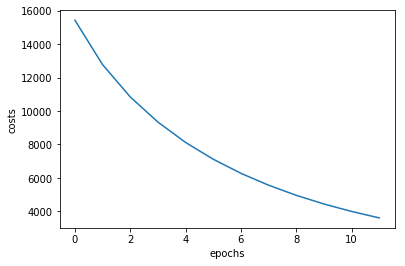

KeyboardInterrupt: 

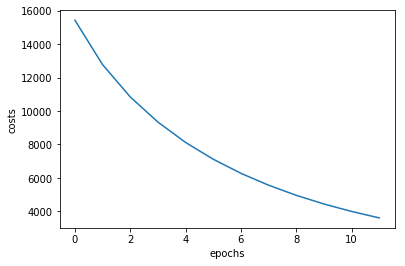

In [15]:
def gd(Y, R, n_movies, n_users, n_params, lamb=0, epochs=10, learning_rate=0.01, callback=None):
    u, s, vh = np.linalg.svd(Y, full_matrices=False)
    d = np.diag(np.sqrt(s))
    X = u@d[:,:n_params]
    Theta = np.transpose(d[:n_params] @ vh)
    
    costs = []
    for i in range(epochs):
        epoch_cost = cost(X, Theta, Y, R, lamb)
        X_grad, Theta_grad = gradient(X, Theta, Y, R, lamb)
        X -= learning_rate * X_grad
        Theta -= learning_rate * Theta_grad
        
        costs.append(epoch_cost)
        if callback:
            callback(i, costs);
    
    GDResult = namedtuple('SGDResult', ['X', 'Theta', 'costs'])
    return GDResult(X=X, Theta=Theta, costs=costs)

Y_mean = np.average(Y, axis=1, weights=R).reshape((-1,1))
Y_norm = R * (Y - Y_mean)
results = gd(Y_norm, R, Y.shape[0], Y.shape[1], n_params=100, lamb=0, epochs=100, learning_rate=0.013, callback=plot_costs)

In [405]:
(results.X @ results.Theta.T) + Y_mean

array([[4.88345805, 3.98274162, 4.62488778, ..., 4.99546536, 4.57668805,
        2.46354949],
       [2.98882529, 3.08399794, 3.24014579, ..., 2.99368355, 2.91896497,
        5.00406076],
       [4.03914831, 2.59507883, 3.14513016, ..., 3.40855888, 4.03502322,
        2.39659587],
       ...,
       [2.        , 2.        , 2.        , ..., 2.        , 2.        ,
        2.        ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ]])

### Normalized Ratings by Adagrad Gradient Descent

epoch 99 done: 44.428201975852744.


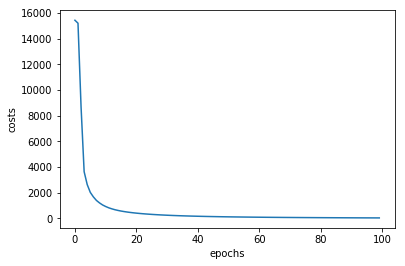

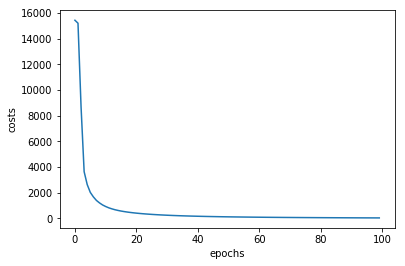

In [406]:
def agd(Y, R, n_movies, n_users, n_params, lamb=0, epochs=10, learning_rate=0.01, eps=1e-6, callback=None):
    u, s, vh = np.linalg.svd(Y, full_matrices=False)
    d = np.diag(np.sqrt(s))
    X = u@d[:,:n_params]
    Theta = np.transpose(d[:n_params] @ vh)
    
    costs = []
    X_cache = np.zeros_like(X)
    Theta_cache = np.zeros_like(Theta)
    for i in range(epochs):
        epoch_cost = cost(X, Theta, Y, R, lamb)
        X_grad, Theta_grad = gradient(X, Theta, Y, R, lamb)
        
        X_cache += X_grad**2
        X += - learning_rate * X_grad / (np.sqrt(X_cache) + eps)
        Theta_cache += Theta_grad**2
        Theta += - learning_rate * Theta_grad / (np.sqrt(Theta_cache) + eps)
        
        costs.append(epoch_cost)
        if callback:
            callback(i, costs);
    
    AGDResult = namedtuple('SGDResult', ['X', 'Theta', 'costs'])
    return AGDResult(X=X, Theta=Theta, costs=costs)

Y_mean = np.average(Y, axis=1, weights=R).reshape((-1,1))
Y_norm = R * (Y - Y_mean)
results = agd(Y_norm, R, Y.shape[0], Y.shape[1], n_params=100, lamb=0, epochs=100, learning_rate=0.11, callback=plot_costs)

In [319]:
(results.X @ results.Theta.T) + Y_mean

array([[4.94804305, 4.02586138, 4.38838451, ..., 5.0050058 , 4.70195795,
        2.0888387 ],
       [3.03680888, 3.18229848, 2.71116389, ..., 2.97796369, 2.2143601 ,
        4.99662086],
       [3.97000088, 2.41718473, 2.94615573, ..., 3.61346779, 3.50020034,
        1.80857816],
       ...,
       [2.        , 2.        , 2.        , ..., 2.        , 2.        ,
        2.        ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ]])

### Normalized Ratings by ADAM Gradient Descent

epoch 99 done: 1.6183570718323332.


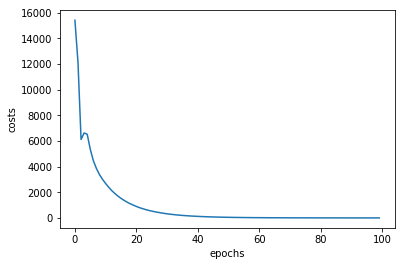

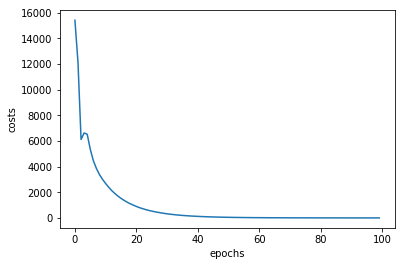

In [417]:
def adamgd(Y, R, n_movies, n_users, n_params, lamb=0, epochs=10, learning_rate=0.01, eps=1e-8, beta1=0.9, beta2=0.999, callback=None):
    u, s, vh = np.linalg.svd(Y, full_matrices=False)
    d = np.diag(np.sqrt(s))
    X = u@d[:,:n_params]
    Theta = np.transpose(d[:n_params] @ vh)
    
    costs = []
    X_m = np.zeros_like(X)
    Theta_m = np.zeros_like(Theta)
    X_v = np.zeros_like(X)
    Theta_v = np.zeros_like(Theta)
    for i in range(epochs):
        epoch_cost = cost(X, Theta, Y, R, lamb)
        X_grad, Theta_grad = gradient(X, Theta, Y, R, lamb)
        
        X_m = beta1*X_m + (1-beta1)*X_grad
        X_v = beta2*X_v + (1-beta2)*(X_grad**2)
        X += - learning_rate * X_m / (np.sqrt(X_v) + eps)
        Theta_m = beta1*Theta_m + (1-beta1)*Theta_grad
        Theta_v = beta2*Theta_v + (1-beta2)*(Theta_grad**2)
        Theta += - learning_rate * Theta_m / (np.sqrt(Theta_v) + eps)
        
        costs.append(epoch_cost)
        if callback:
            callback(i, costs);
    
    ADAMGDResult = namedtuple('SGDResult', ['X', 'Theta', 'costs'])
    return ADAMGDResult(X=X, Theta=Theta, costs=costs)

Y_mean = np.average(Y, axis=1, weights=R).reshape((-1,1))
Y_norm = R * (Y - Y_mean)
results = adamgd(Y_norm, R, Y.shape[0], Y.shape[1], n_params=100, lamb=0, epochs=100, learning_rate=0.03, callback=plot_costs)

In [418]:
(results.X @ results.Theta.T) + Y_mean

array([[4.98703463, 3.99946848, 3.84798728, ..., 4.99877936, 4.79745432,
        2.65467606],
       [3.00385433, 0.89516776, 3.37819489, ..., 0.98227201, 2.92077684,
        5.00152969],
       [3.99849776, 4.10765562, 2.60673408, ..., 4.13563122, 4.17994759,
        3.21549063],
       ...,
       [2.        , 2.        , 2.        , ..., 2.        , 2.        ,
        2.        ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ]])

### Normalized Ratings by Stochastic Gradient Descent

epoch 2 done: 11844.475204621513.


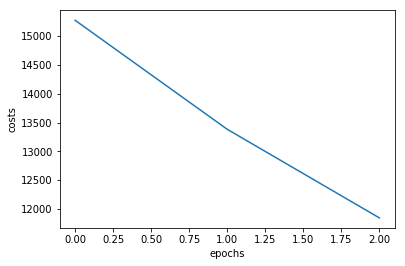

KeyboardInterrupt: 

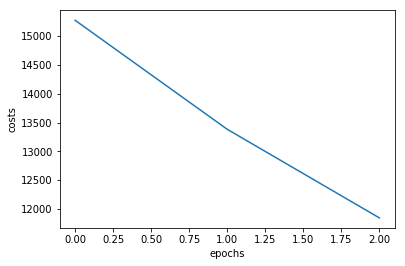

In [321]:
def sgd(Y, R, n_movies, n_users, n_params, lamb=0, epochs=10, learning_rate=0.01, callback=None):
    u, s, vh = np.linalg.svd(Y, full_matrices=False)
    d = np.diag(np.sqrt(s))
    X = u@d[:,:n_params]
    Theta = np.transpose(d[:n_params] @ vh)
    
    costs = []
    indices = np.argwhere(R)
    np.random.shuffle(indices)
    for i in range(epochs):
        epoch_cost = 0
        for ix, it in indices:
            x, t, r = X[ix], Theta[it], Y[ix, it]
            epoch_cost += (1/2) * ((t.T @ x - r)**2 + lamb * (np.sum(x**2) + np.sum(t**2)))
            X[ix] -= learning_rate * ((t.T @ x - r)*t + lamb*x)
            Theta[it] -= learning_rate * ((t.T @ x - r)*x + lamb*t)
        
        costs.append(epoch_cost)
        if callback:
            callback(i, costs)
    
    SGDResult = namedtuple('SGDResult', ['X', 'Theta', 'costs'])
    return SGDResult(X=X, Theta=Theta, costs=costs)

Y_mean = np.average(Y, axis=1, weights=R).reshape((-1,1))
Y_norm = R * (Y - Y_mean)
results = sgd(Y_norm, R, Y.shape[0], Y.shape[1], n_params=100, lamb=0, epochs=100, learning_rate=0.01, callback=plot_costs)

In [206]:
(results.X @ results.Theta.T) + Y_mean

array([[4.85600914, 3.97332913, 4.56501713, ..., 4.99174633, 4.55743009,
        2.62642833],
       [2.97227653, 3.05818065, 3.30452264, ..., 3.00702179, 2.93179169,
        4.99579538],
       [4.06125878, 2.56048199, 3.16290043, ..., 3.40397088, 3.94512326,
        2.41693417],
       ...,
       [2.        , 2.        , 2.        , ..., 2.        , 2.        ,
        2.        ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ]])

### Normalized Ratings by Adagrad Stochastic Gradient Descent

epoch 1 done: 7349024.590850858.


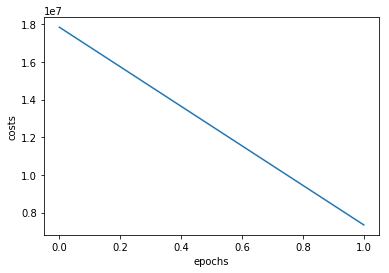

KeyboardInterrupt: 

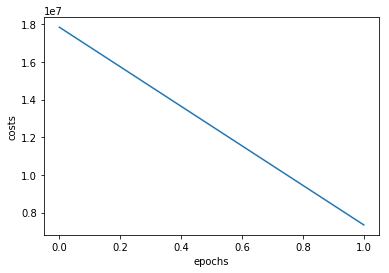

In [407]:
def asgd(Y, R, n_movies, n_users, n_params, lamb=0, epochs=10, learning_rate=0.01, eps=1e-6, callback=None):
    u, s, vh = np.linalg.svd(Y, full_matrices=False)
    d = np.diag(np.sqrt(s))
    X = u@d[:,:n_params]
    Theta = np.transpose(d[:n_params] @ vh)
    
    costs = []
    indices = np.argwhere(R)
    np.random.shuffle(indices)
    X_cache = np.zeros_like(X)
    Theta_cache = np.zeros_like(Theta)
    for i in range(epochs):
        epoch_cost = 0
        for ix, it in indices:
            x, t, r = X[ix], Theta[it], Y[ix, it]
            epoch_cost += (1/2) * ((t.T @ x - r)**2 + lamb * (np.sum(x**2) + np.sum(t**2)))
            X_grad = ((t.T @ x - r)*t + lamb*x)
            Theta_grad = ((t.T @ x - r)*x + lamb*t)
            
            X_cache[ix] += X_grad**2
            X[ix] += - learning_rate * X_grad / (np.sqrt(X_cache[ix]) + eps)
            Theta_cache[it] += Theta_grad**2
            Theta[it] += - learning_rate * Theta_grad / (np.sqrt(Theta_cache[it]) + eps)
        
        costs.append(epoch_cost)
        if callback:
            callback(i, costs)
    
    SGDResult = namedtuple('SGDResult', ['X', 'Theta', 'costs'])
    return SGDResult(X=X, Theta=Theta, costs=costs)

Y_mean = np.average(Y, axis=1, weights=R).reshape((-1,1))
Y_norm = R * (Y - Y_mean)
results = asgd(Y_norm, R, Y.shape[0], Y.shape[1], n_params=100, lamb=0, epochs=100, learning_rate=1, callback=plot_costs)

In [334]:
(results.X @ results.Theta.T) + Y_mean

array([[4.94804305, 4.02586138, 4.38838451, ..., 5.0050058 , 4.70195795,
        2.0888387 ],
       [3.03680888, 3.18229848, 2.71116389, ..., 2.97796369, 2.2143601 ,
        4.99662086],
       [3.97000088, 2.41718473, 2.94615573, ..., 3.61346779, 3.50020034,
        1.80857816],
       ...,
       [2.        , 2.        , 2.        , ..., 2.        , 2.        ,
        2.        ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ]])

## Latent Factors Method

In [18]:
def baseline_cost(X, Theta, Y, R, bias, bias_items, bias_users, lamb=0):
    X_reg = (lamb/2) * np.sum(X**2)
    Theta_reg = (lamb/2) * np.sum(Theta**2)
    bi_reg = (lamb/2) * np.sum(bias_items**2)
    bu_reg = (lamb/2) * np.sum(bias_users**2)
    return (np.sum(np.square(R * (bias + bias_users + bias_items + (X @ Theta.T) - Y))) / 2) + X_reg + Theta_reg + bi_reg + bu_reg

In [19]:
def baseline_gradient(X, Theta, Y, R, bias, bias_items, bias_users, lamb=0):
    diffs = R * (bias + bias_users + bias_items + (X @ Theta.T) - Y) #(1682, 943)
    X_reg = lamb * X #(1682, 10)
    Theta_reg = lamb * Theta #(943, 10)
    bi_reg = lamb * bias_items #(1682, 1)
    bu_reg = lamb * bias_users #(1, 943)
    X_grad = diffs @ Theta + X_reg 
    Theta_grad = diffs.T @ X + Theta_reg
    bi_grad = np.sum(diffs) + bi_reg
    bu_grad = np.sum(diffs) + bu_reg
    return X_grad, Theta_grad, bi_grad, bu_grad

### Latent Factors with Baseline by Adagrad Gradient Descent

epoch 99 done: 45.081010707180404.


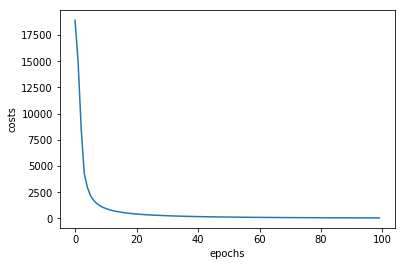

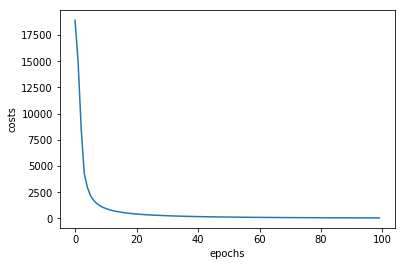

In [20]:
def agd2(Y, R, n_movies, n_users, n_params, lamb=0, epochs=10, learning_rate=0.01, eps=1e-6, callback=None):
    u, s, vh = np.linalg.svd(Y, full_matrices=False)
    d = np.diag(np.sqrt(s))
    X = u@d[:,:n_params]
    Theta = np.transpose(d[:n_params] @ vh)
    
    bias = np.average(Y, weights=R)
    bias_items = (np.average(Y, axis=1, weights=R) - bias).reshape(-1,1)
    bias_users = (np.average(Y, axis=0, weights=R) - bias).reshape(1,-1)
    
    costs = []
    X_cache = np.zeros_like(X)
    Theta_cache = np.zeros_like(Theta)
    bias_users_cache =  np.zeros_like(bias_users)
    bias_items_cache = np.zeros_like(bias_items)
    for i in range(epochs):
        epoch_cost = baseline_cost(X, Theta, Y, R, bias, bias_items, bias_users, lamb)
        print(bias_items.shape)
        X_grad, Theta_grad, bias_items_grad, bias_users_grad = baseline_gradient(X, Theta, Y, R, bias, bias_items, bias_users, lamb)
        
        X_cache += X_grad**2
        X += - learning_rate * X_grad / (np.sqrt(X_cache) + eps)
        Theta_cache += Theta_grad**2
        Theta += - learning_rate * Theta_grad / (np.sqrt(Theta_cache) + eps)
        bias_users_cache += bias_users_grad**2
        bias_users += - learning_rate * bias_users_grad / (np.sqrt(bias_users_cache) + eps)
        bias_items_cache += bias_items_grad**2
        bias_items += - learning_rate * bias_items_grad / (np.sqrt(bias_items_cache) + eps)
        
        costs.append(epoch_cost)
        if callback:
            callback(i, costs);
    
    AGD2Result = namedtuple('SGDResult', ['X', 'Theta', 'bu', 'bi', 'costs'])
    return AGD2Result(X=X, Theta=Theta, bu=bias_users, bi=bias_items, costs=costs)

Y_mean = np.average(Y, axis=1, weights=R).reshape((-1,1))
Y_norm = R * (Y - Y_mean)
results = agd2(Y_norm, R, Y.shape[0], Y.shape[1], n_params=100, lamb=0, epochs=100, learning_rate=0.11, callback=plot_costs)

### Latent Factors with Baseline by ADAM Gradient Descent

epoch 199 done: 0.1468562468250032.


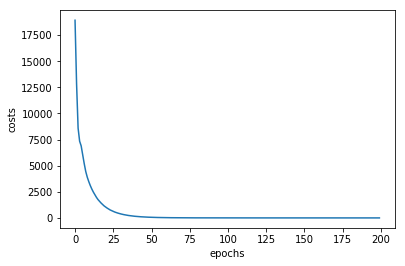

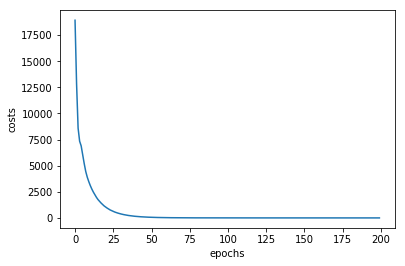

In [424]:
def adamgd2(Y, R, n_movies, n_users, n_params, lamb=0, epochs=10, learning_rate=0.01, eps=1e-8, beta1=0.9, beta2=0.999, callback=None):
    u, s, vh = np.linalg.svd(Y, full_matrices=False)
    d = np.diag(np.sqrt(s))
    X = u@d[:,:n_params]
    Theta = np.transpose(d[:n_params] @ vh)
    
    bias = np.average(Y, weights=R)
    bias_items = (np.average(Y, axis=1, weights=R) - bias).reshape(-1,1)
    bias_users = (np.average(Y, axis=0, weights=R) - bias).reshape(1,-1)
    
    costs = []
    X_m = np.zeros_like(X)
    X_v = np.zeros_like(X)
    Theta_m = np.zeros_like(Theta)
    Theta_v = np.zeros_like(Theta)
    bias_users_m =  np.zeros_like(bias_users)
    bias_users_v =  np.zeros_like(bias_users)
    bias_items_m = np.zeros_like(bias_items)
    bias_items_v = np.zeros_like(bias_items)
    for i in range(epochs):
        epoch_cost = baseline_cost(X, Theta, Y, R, bias, bias_items, bias_users, lamb)
        print(bias_items.shape)
        X_grad, Theta_grad, bias_items_grad, bias_users_grad = baseline_gradient(X, Theta, Y, R, bias, bias_items, bias_users, lamb)
        
        X_m = beta1*X_m + (1-beta1)*X_grad
        X_v = beta2*X_v + (1-beta2)*(X_grad**2)
        X += - learning_rate * X_m / (np.sqrt(X_v) + eps)
        Theta_m = beta1*Theta_m + (1-beta1)*Theta_grad
        Theta_v = beta2*Theta_v + (1-beta2)*(Theta_grad**2)
        Theta += - learning_rate * Theta_m / (np.sqrt(Theta_v) + eps)
        bias_users_m = beta1*bias_users_m + (1-beta1)* bias_users_grad
        bias_users_v = beta2*bias_users_v + (1-beta2)*(bias_users_grad**2)
        bias_users += - learning_rate * bias_users_m / (np.sqrt(bias_users_v) + eps)
        bias_items_m = beta1*bias_items_m + (1-beta1)* bias_items_grad
        bias_items_v = beta2*bias_items_v + (1-beta2)*(bias_items_grad**2)
        bias_items += - learning_rate * bias_items_m / (np.sqrt(bias_items_v) + eps)
        
        costs.append(epoch_cost)
        if callback:
            callback(i, costs);
    
    ADAMGD2Result = namedtuple('SGDResult', ['X', 'Theta', 'bu', 'bi', 'costs'])
    return ADAMGD2Result(X=X, Theta=Theta, bu=bias_users, bi=bias_items, costs=costs)

Y_mean = np.average(Y, axis=1, weights=R).reshape((-1,1))
Y_norm = R * (Y - Y_mean)
results = adamgd2(Y_norm, R, Y.shape[0], Y.shape[1], n_params=100, lamb=0, epochs=200, learning_rate=0.03, callback=plot_costs)

### Latent Factors with Baseline by Stochastic Gradient Descent

In [1]:
def baseline_sgd(Y, R, n_movies, n_users, n_params, lamb=0, epochs=10, learning_rate=0.01, callback=None):
    u, s, vh = np.linalg.svd(Y, full_matrices=False)
    d = np.diag(np.sqrt(s))
    X = u@d[:,:n_params]
    Theta = np.transpose(d[:n_params] @ vh)
    
    bias = np.average(Y, weights=R)
    bias_items = np.average(Y, axis=1, weights=R) - bias
    bias_users = np.average(Y, axis=0, weights=R) - bias

    costs = []
    indices = np.argwhere(R)
    np.random.shuffle(indices)
    for i in range(epochs):
        epoch_cost = 0
        for ix, it in indices:
            x, t, r, bu, bi = X[ix], Theta[it], Y[ix, it], bias_users[it], bias_items[ix]
            print(t)
            epoch_cost += (1/2) * ((bias + bu + bi + (t.T @ x) - r)**2 + lamb*(np.sum(x**2) + np.sum(t**2) + bu**2 + bi**2))
            X[[ix]] -= learning_rate * ((bias + bu + bi + (t.T @ x) - r)*t + lamb*x)
            Theta[[it]] -= learning_rate * ((bias + bu + bi + (t.T @ x) - r)*x + lamb*t)
            bias_users[it] -= learning_rate * ((bias + bu + bi + (t.T @ x) - r) + lamb*bu)
            bias_items[ix] -= learning_rate * ((bias + bu + bi + (t.T @ x) - r) + lamb*bi)
        
        costs.append(epoch_cost)
        if callback:
            callback(i, costs)
    
    BSGDResult = namedtuple('SGDResult', ['X', 'Theta', 'bu', 'bi', 'costs'])
    return BSGDResult(X=X, Theta=Theta, bu=bias_users, bi=bias_items, costs=costs)

results = baseline_sgd(Y, R, Y.shape[0], Y.shape[1], n_params=100, lamb=0, epochs=100, learning_rate=0.01, callback=plot_costs)

NameError: name 'Y' is not defined

In [16]:
(np.average(Y, axis=1, weights=R).reshape((-1,1)) + (results.X @ results.Theta.T) + results.bi.reshape(-1,1) + results.bu.reshape(1,-1))

NameError: name 'results' is not defined

In [388]:
Y

array([[5., 4., 0., ..., 5., 0., 0.],
       [3., 0., 0., ..., 0., 0., 5.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
movies = np.fromregex(file='movie_ids.txt',
             dtype=[('index', 'i4'), ('title', 'U20')],
             regexp=r'(\d+) (.*)',
             encoding='LATIN-1')

In [249]:
X[np.ix_([100,200,100], [5,7, 7])]

array([[-0.1589416 , -0.54038318, -0.54038318],
       [-0.07609772, -0.30191909, -0.30191909],
       [-0.1589416 , -0.54038318, -0.54038318]])

In [250]:
X[[100,200,100], [5,7, 7]]

array([-0.1589416 , -0.30191909, -0.54038318])